### [Day2]
* データの標準化を行った。
* ホールドアウト法、交差検証を用いた汎化性能の評価を行った。
* ホールドアウト法を用いることでDay1に比べ15 %程度制度が低下した一方で、交差検証ではDay1とほぼ同程度の値が出ており安定していない。精度が高すぎるような気がするため、事前の処理などを見直してみる予定です。

In [1]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from common_func import plot_decision_regions

In [2]:
#データセットのインポート
df_project=pd.read_csv("../1_data/ks-projects-201801.csv")[["goal","pledged","state","backers"]]
#df_project=pd.read_csv("../1_data/ks-projects-201801.csv")[["goal","pledged","state","backers","country"]]

#表示
display(df_project.head(100))
df_project.describe()
df_project.info()

,goal,pledged,state,backers
0,1000.0,0.00,failed,0
1,30000.0,2421.00,failed,15
2,45000.0,220.00,failed,3
3,5000.0,1.00,failed,1
4,19500.0,1283.00,canceled,14
5,50000.0,52375.00,successful,224
6,1000.0,1205.00,successful,16
7,25000.0,453.00,failed,40
8,125000.0,8233.00,canceled,58
9,65000.0,6240.57,canceled,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 4 columns):
goal       378661 non-null float64
pledged    378661 non-null float64
state      378661 non-null object
backers    378661 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 11.6+ MB


(array([3.78593e+05, 4.40000e+01, 9.00000e+00, 1.10000e+01, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([     0. ,  21938.2,  43876.4,  65814.6,  87752.8, 109691. ,
        131629.2, 153567.4, 175505.6, 197443.8, 219382. ]),
 <a list of 10 Patch objects>)

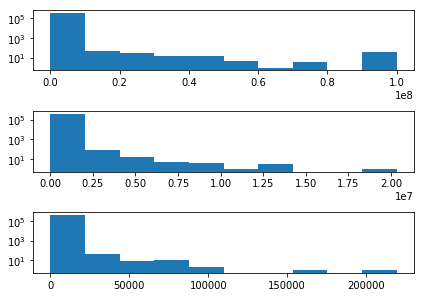

In [3]:
plt.subplot(3,1,1)
plt.hist(df_project.goal, log=True)
plt.tight_layout()
plt.subplot(3,1,2)
plt.hist(df_project.pledged, log=True)
plt.subplot(3,1,3)
plt.hist(df_project.backers, log=True)

In [4]:
#2値に分ける
df_project.loc[df_project['state'] == 'successful','state_n']=1
df_project.loc[df_project['state'] != 'successful','state_n']=0
display(df_project.head())

,goal,pledged,state,backers,state_n
0,1000.0,0.0,failed,0,0.0
1,30000.0,2421.0,failed,15,0.0
2,45000.0,220.0,failed,3,0.0
3,5000.0,1.0,failed,1,0.0
4,19500.0,1283.0,canceled,14,0.0


In [5]:
#stateを削除
drop_columns = ['state']
df_project = df_project.drop(drop_columns, axis = 1)

In [6]:
df_project.isnull().sum()

goal       0
pledged    0
backers    0
state_n    0
dtype: int64

In [7]:
#ダミー変数作成
#df_project=pd.get_dummies(df_project)
#display(df_project.head())

In [8]:
#相関マップ
df_project.corr().style.background_gradient()

,goal,pledged,backers,state_n
goal,1,0.00735789,0.00401195,-0.0243322
pledged,0.00735789,1,0.717079,0.111534
backers,0.00401195,0.717079,1,0.129109
state_n,-0.0243322,0.111534,0.129109,1


In [9]:
y = df_project["state_n"].values
X = df_project.drop('state_n', axis=1).values

In [10]:
#ホールドアウト法を使用
#test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

(array([7.5704e+04, 1.0000e+01, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 7.0000e+00]),
 array([-4.14662378e-02,  8.27528434e+00,  1.65920349e+01,  2.49087855e+01,
         3.32255361e+01,  4.15422866e+01,  4.98590372e+01,  5.81757878e+01,
         6.64925383e+01,  7.48092889e+01,  8.31260395e+01]),
 <a list of 10 Patch objects>)

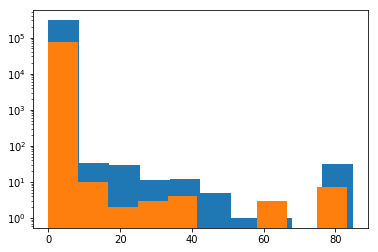

In [11]:
#標準化を実施
#stdsc = StandardScaler()
#X_train = stdsc.fit_transform(X_train)
#plt.hist(X_train[:, 0], log=True) 
#stdsc = StandardScaler()
#X_test = stdsc.fit_transform(X_test)
#plt.hist(X_test[:, 0], log=True) 

In [12]:
#ロジスティック回帰を実装
#clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
#clf.fit(X_train, y_train)

# 重みを取得して表示
#w0 = clf.intercept_[0]
#w1 = clf.coef_[0, 0]
#w2 = clf.coef_[0, 1]
#w3 = clf.coef_[0, 2]
#print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

w0 = -2.174, w1 = -93.504, w2 = 9.806, w3 = 14.675


In [13]:
# ラベルを予測
#y_est = clf.predict(X_train)

# 対数尤度を表示
#print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))

# 正答率を表示
#print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))

対数尤度 = -5.432
正答率 = 84.272%


In [14]:
# ラベルを予測
#y_est2 = clf.predict(X_test)

# 対数尤度を表示
#print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est2)))

# 正答率を表示
#print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est2)))

対数尤度 = -5.318
正答率 = 84.604%


In [16]:
# 予測値と正解のクロス集計
#conf_mat2 = pd.DataFrame(confusion_matrix(y_test, y_est2), 
#                        index=['正解 = 失敗', '正解 = 成功'], 
#                        columns=['予測 = 失敗', '予測 = 成功'])
#conf_mat2

,予測 = 失敗,予測 = 成功
正解 = 失敗,47753,1330
正解 = 成功,10330,16320


In [15]:
#交差検証法
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # 予測を実行
    y_est = clf.predict(X_test)
    y_est_t = clf.predict(X_train)

    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))
    print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_t)))

    # 正答率を表示
    print('正答率_test = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))
    print('正答率_train = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_t)))
    
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    print()


対数尤度 = -0.644
対数尤度 = -0.627
正答率_test = 98.137%
正答率_train = 98.185%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48492,591
正解 = 成功,820,25830



対数尤度 = -0.950
対数尤度 = -0.929
正答率_test = 97.248%
正答率_train = 97.309%


,予測 = 失敗,予測 = 成功
正解 = 失敗,47191,1596
正解 = 成功,488,26457



対数尤度 = -0.649
対数尤度 = -0.633
正答率_test = 98.120%
正答率_train = 98.167%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48380,570
正解 = 成功,854,25928



対数尤度 = -0.417
対数尤度 = -0.428
正答率_test = 98.792%
正答率_train = 98.760%


,予測 = 失敗,予測 = 成功
正解 = 失敗,47982,847
正解 = 成功,68,26835



対数尤度 = -0.296
対数尤度 = -0.284
正答率_test = 99.144%
正答率_train = 99.179%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48435,621
正解 = 成功,27,26649


In [ ]:
#SVM
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 1]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)